## Logistic Regression Example

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import log, dot, e
from numpy.random import rand, multivariate_normal, shuffle

In [5]:
class LogisticRegression:
    def __init__ (self,lr=0.0001, itera=500000):
        self.lr = lr
        self.itera = itera
        self.w = None
        self.b = None

    def fit(self, X, Y):
        X = np.c_[X, np.ones(X.shape[0])]    
        weights = rand(X.shape[1])
        N = len(X)
                 
        for _ in range(self.itera):        
            Y_pred = self.sigmoid(dot(X, weights))
            weights -= self.lr * dot(X.T,  Y_pred - Y) / N
            
        self.weights = weights

    def sigmoid(self,x):
        return (1/(1+np.exp(-x)))
        
    def predict(self, X):
        X = np.c_[X, np.ones(X.shape[0])] 
        z = dot(X, self.weights)
        return [1 if i > 0.5 else 0 for i in self.sigmoid(z)]
    
    def accuracy(self,Y_act,Y_predi):
        counter = 0
        for i in range (len(Y_act)):
            if Y_act[i]==Y_predi[i]:
                counter += 1
        return ((counter/len(Y_act))*100)
    
    def predict_proba(self, X):
        X = np.c_[X, np.ones(X.shape[0])] 
        z = dot(X, self.weights)
        return np.array((self.sigmoid(z),1-self.sigmoid(z))).T

In [6]:
def generate_dataset():
    mean1 = [2, 20]
    cov1 = [[5, 10], [10, 200]]
    
    mean2 = [12, 40]
    cov2 = [[15, 5], [5, 50]]
    
    class1 = multivariate_normal(mean1, cov1, 4000)
    class2 = multivariate_normal(mean2, cov2, 4000)
    
    X = np.concatenate((class1, class2), axis=0)
    Y = np.concatenate((np.array([0] * 4000), np.array([1]*4000)))
    return X,Y
    
def train_test_split(X, Y, test_fraction=0.3):
    indices = np.random.permutation(X.shape[0])
    train_size = int(X.shape[0] * (1 - test_fraction))
    training_idx, test_idx = indices[:train_size], indices[train_size:]
    return X[training_idx,:], X[test_idx,:], Y[training_idx], Y[test_idx]



<AxesSubplot:>

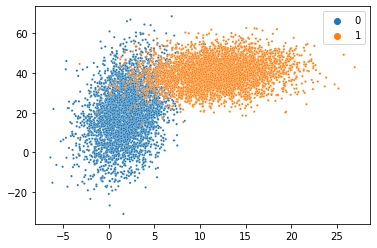

In [7]:
X,Y = generate_dataset()
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)
sns.scatterplot(x=X[:,0], y=X[:,1], s=5, hue=Y)

In [8]:
regression = LogisticRegression()
regression.fit(X_train,Y_train)
Y_predicted = regression.predict(X_test)
# print(Y_predicted)
Accu = regression.accuracy(Y_test,Y_predicted) 
print(Accu)



94.41666666666667


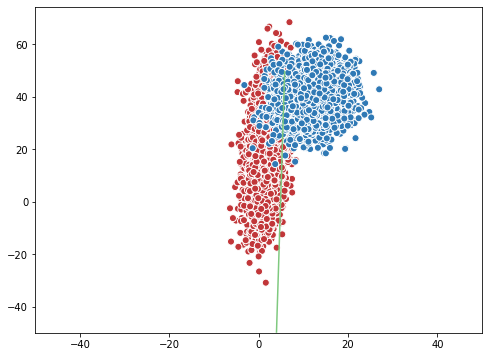

In [9]:
xx, yy = np.mgrid[-50:50:.1, -50:50:.1]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = regression.predict_proba(grid)[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 6))
ax.contour(xx, yy, probs, levels=[.5], cmap="Accent", vmin=0, vmax=10000)

ax.scatter(X[100:,0], X[100:, 1], c=Y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

In [10]:
class CART(object):
    def __init__(self, max_depth = 4):
        self.feature = None
        self.label = None
        self.n_samples = None
        self.gain = None
        self.left = None
        self.right = None
        self.threshold = None
        self.depth = 0
        self.root = None
        self.max_depth = max_depth

    def fit(self, features, target):
        self.root = CART()
        self.root._grow_tree(features, target)
        self.root._prune(self.max_depth, self.root.n_samples)

    def predict(self, features):
        return np.array([self.root._predict(f) for f in features])

    def print_tree(self):
        self.root._show_tree(0, ' ')

    def _grow_tree(self, features, target):
        self.n_samples = features.shape[0] 

        if len(np.unique(target)) == 1:
            self.label = target[0]
            return

        best_gain = 0.0
        best_feature = None
        best_threshold = None

        self.label = max([(c, len(target[target == c])) for c in np.unique(target)], key = lambda x : x[1])[0]

        impurity_node = self._calc_impurity(target)
        
        for col in range(features.shape[1]):
            feature_level = np.unique(features[:,col])
            thresholds = (feature_level[:-1] + feature_level[1:]) / 2.0

            for threshold in thresholds:
                target_l = target[features[:,col] <= threshold]
                impurity_l = self._calc_impurity(target_l)
                n_l = float(target_l.shape[0]) / self.n_samples

                target_r = target[features[:,col] > threshold]
                impurity_r = self._calc_impurity(target_r)
                n_r = float(target_r.shape[0]) / self.n_samples

                impurity_gain = impurity_node - (n_l * impurity_l + n_r * impurity_r)
                if impurity_gain > best_gain:
                    best_gain = impurity_gain
                    best_feature = col
                    best_threshold = threshold

        self.feature = best_feature
        self.gain = best_gain
        self.threshold = best_threshold
        self._split_tree(features, target)

    def _split_tree(self, features, target):
        features_l = features[features[:, self.feature] <= self.threshold]
        target_l = target[features[:, self.feature] <= self.threshold]
        self.left = CART()
        self.left.depth = self.depth + 1
        self.left._grow_tree(features_l, target_l)

        features_r = features[features[:, self.feature] > self.threshold]
        target_r = target[features[:, self.feature] > self.threshold]
        self.right = CART()
        self.right.depth = self.depth + 1
        self.right._grow_tree(features_r, target_r)

    def _calc_impurity(self, target):
        return 1.0 - sum([(float(len(target[target == c])) / float(target.shape[0])) ** 2.0 for c in np.unique(target)])
        

    def _prune(self, max_depth, n_samples):
        if self.feature is None:
            return

        self.left._prune(max_depth, n_samples)
        self.right._prune(max_depth, n_samples)

        pruning = False

        if self.depth >= max_depth:
            pruning = True

        if pruning is True:
            self.left = None
            self.right = None
            self.feature = None

    def _predict(self, d):
        if self.feature != None:
            if d[self.feature] <= self.threshold:
                return self.left._predict(d)
            else:
                return self.right._predict(d)
        else: 
            return self.label

    def _show_tree(self, depth, cond):
        base = '    ' * depth + cond
        if self.feature != None:
            print(base + 'if X[' + str(self.feature) + '] <= ' + str(self.threshold))
            self.left._show_tree(depth+1, 'then ')
            self.right._show_tree(depth+1, 'else ')
        else:
            print(base + '{value: ' + str(self.label) + ', samples: ' + str(self.n_samples) + '}')

In [11]:
cart = CART(max_depth = 5)
cart.fit(X_train, Y_train)
Y_pred = cart.predict(X_test)
cart.print_tree()
print('Accuracy: ',np.mean(Y_pred==Y_test))

 if X[0] <= 5.76483429170217
    then if X[1] <= 30.88308881138172
        then if X[1] <= 28.496146112414785
            then if X[1] <= 25.41743857230639
                then if X[1] <= 20.397827681367446
                    then {value: 0, samples: 1389}
                    else {value: 0, samples: 381}
                else if X[1] <= 25.423579523718544
                    then {value: 1, samples: 1}
                    else {value: 0, samples: 202}
            else if X[0] <= 5.137661597902032
                then if X[1] <= 28.515432461365922
                    then {value: 1, samples: 1}
                    else {value: 0, samples: 128}
                else if X[0] <= 5.442252355173646
                    then {value: 1, samples: 2}
                    else {value: 0, samples: 2}
        else if X[0] <= 4.165972948482343
            then if X[0] <= 3.0409896295523433
                then if X[0] <= 2.517473195825981
                    then {value: 0, samples: 311}
             